For this challenge you have two options for how to use neural networks . Choose one of the following:

* Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in. DO NOT USE either the MNIST digit recognition database or the iris data set. They’ve been worked on in very public ways very very many times and the code is easily available. (However, that code could be a useful resource to refer to). 

OR

* Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

Once you've chosen which option you prefer, get to modeling and submit your work below.



In [126]:
#from __future__ import print_function

#print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.13s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.18s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.20s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.19s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.25s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.21s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.19s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.19s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.19s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.21s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.17s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.18s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.17s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.20s
[BernoulliRBM] Iteration 15, 

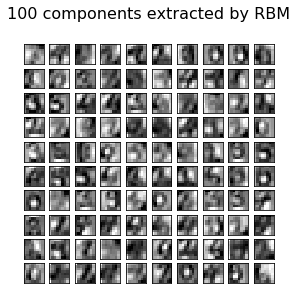

In [127]:
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [114]:
print(X)

[[0.         0.         0.31249806 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.6249961  0.         0.        ]
 [0.         0.         0.         ... 0.9999938  0.56249654 0.        ]
 ...
 [0.         0.         0.         ... 0.9999938  0.         0.        ]
 [0.         0.         0.         ... 0.9999938  0.12499923 0.        ]
 [0.         0.         0.         ... 0.9999938  0.4999969  0.        ]]


In [115]:
cct = pd.read_csv('Cancer CT overview.csv')
cct = cct.drop(['Unnamed: 0'], axis=1)
cct = cct[['id','Age','Contrast','ContrastTag','raw_input_path','tiff_name','dicom_name']]
print(cct.head())
print(cct.info())

   id  Age  Contrast ContrastTag  \
0   0   60      True        NONE   
1   1   69      True        NONE   
2   2   74      True     APPLIED   
3   3   75      True        NONE   
4   4   56      True        NONE   

                                      raw_input_path  \
0   ../data/50_50_dicom_cases\Contrast\00001 (1).dcm   
1  ../data/50_50_dicom_cases\Contrast\00001 (10).dcm   
2  ../data/50_50_dicom_cases\Contrast\00001 (11).dcm   
3  ../data/50_50_dicom_cases\Contrast\00001 (12).dcm   
4  ../data/50_50_dicom_cases\Contrast\00001 (13).dcm   

                            tiff_name                          dicom_name  
0  ID_0000_AGE_0060_CONTRAST_1_CT.tif  ID_0000_AGE_0060_CONTRAST_1_CT.dcm  
1  ID_0001_AGE_0069_CONTRAST_1_CT.tif  ID_0001_AGE_0069_CONTRAST_1_CT.dcm  
2  ID_0002_AGE_0074_CONTRAST_1_CT.tif  ID_0002_AGE_0074_CONTRAST_1_CT.dcm  
3  ID_0003_AGE_0075_CONTRAST_1_CT.tif  ID_0003_AGE_0075_CONTRAST_1_CT.dcm  
4  ID_0004_AGE_0056_CONTRAST_1_CT.tif  ID_0004_AGE_0056_CONTRAST_1

In [118]:
cct['Contrast'] = np.where(cct['Contrast']==True,1,0)
print(cct['Contrast'].value_counts())

1    50
0    50
Name: Contrast, dtype: int64


In [119]:
IS_LOCAL = False
import numpy as np
import pandas as pd
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

if(IS_LOCAL):
    import pydicom as dicom
#else:
    #import dicom
import os

if(IS_LOCAL):
    PATH="../input/siim-medical-image/"
else:
    PATH="Cancer CT scans/"
print(os.listdir(PATH))

print("Number of TIFF images:", len(os.listdir(os.path.join(PATH,"tiff_images"))))

tiff_data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+'tiff_images/*.tif')])

def process_data(path):
    data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+path)])
    data['file'] = data['path'].map(os.path.basename)
    data['ID'] = data['file'].map(lambda x: str(x.split('_')[1]))
    data['Age'] = data['file'].map(lambda x: int(x.split('_')[3]))
    data['Contrast'] = data['file'].map(lambda x: bool(int(x.split('_')[5])))
    data['Modality'] = data['file'].map(lambda x: str(x.split('_')[6].split('.')[-2]))
    return data

tiff_data = process_data('tiff_images/*.tif')

tiff_data['img_data'] = tiff_data['path'].apply(func=imread) 
tiff_data['Contrast'] = np.where(tiff_data['Contrast']==True,1,0)

print(tiff_data.head())
#tiff_data['img_data'] = tiff_data['img_data'].astype('int64')
print(tiff_data.info())

['tiff_images', 'dicom_dir', 'Cancer CT overview.csv', 'full_archive.npz']
Number of TIFF images: 100
                                                path  \
0  Cancer CT scans/tiff_images/ID_0084_AGE_0067_C...   
1  Cancer CT scans/tiff_images/ID_0088_AGE_0067_C...   
2  Cancer CT scans/tiff_images/ID_0020_AGE_0066_C...   
3  Cancer CT scans/tiff_images/ID_0039_AGE_0074_C...   
4  Cancer CT scans/tiff_images/ID_0004_AGE_0056_C...   

                                 file    ID  Age  Contrast Modality  \
0  ID_0084_AGE_0067_CONTRAST_0_CT.tif  0084   67         0       CT   
1  ID_0088_AGE_0067_CONTRAST_0_CT.tif  0088   67         0       CT   
2  ID_0020_AGE_0066_CONTRAST_1_CT.tif  0020   66         1       CT   
3  ID_0039_AGE_0074_CONTRAST_1_CT.tif  0039   74         1       CT   
4  ID_0004_AGE_0056_CONTRAST_1_CT.tif  0004   56         1       CT   

                                            img_data  
0  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...  
1  [[-2048.0, -2048.0, -

In [128]:
X = tiff_data.img_data
#X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)
y = tiff_data.Contrast
print(X)

0     [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...
1     [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
2     [[-1006.0, -1003.0, -998.0, -999.0, -1000.0, -...
3     [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
4     [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...
5     [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...
6     [[-996.0, -993.0, -994.0, -997.0, -998.0, -994...
7     [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
8     [[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...
9     [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...
10    [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
11    [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
12    [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...
13    [[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...
14    [[-1011.0, -1003.0, -994.0, -994.0, -1001.0, -...
15    [[-997.0, -999.0, -1001.0, -999.0, -995.0, -99...
16    [[-982.0, -1001.0, -1014.0, -1009.0, -992.0, -...
17    [[-1024.0, -1024.0, -1024.0, -1024.0, -102

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

# #############################################################################
# Evaluation

y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, y_pred)))

y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

ValueError: setting an array element with a sequence.